In [1]:
import time
import warnings

import numpy as np
import numpy.linalg as LA
import scipy.linalg as SLA
from scipy import io
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from scipy.stats import ortho_group

# RNN cells #
1. Explicit
2. Implicit-midpoint

In [2]:
class rnn_const_exp(layers.Layer):
    def __init__(self, dimx, dimz, c, k, force, E):
        super(rnn_const_exp, self).__init__()
        self.c = c
        self.k = k
        self.E = tf.constant(E, dtype=tf.float32)
        self.dimx = dimx
        self.units = dimz
        self.state_size = (self.units, 2)
        self.F = force # force function
        
    def build(self, input_shapes):
        # R's entries are likely to be small
        self.R = self.add_weight(
            shape=(self.dimx, self.units), initializer=keras.initializers.Orthogonal(), name="fsi_coupling"
        )
        # W is supposed to be a small perturbation of the identity matrix
        # self.W = self.add_weight(shape=(self.units, self.units), initializer="orthogonal", name="hidden_opt")
        
        self.nd = self.add_weight(
            shape=(self.units,), initializer=keras.initializers.Constant(value=0.1), 
            constraint=keras.constraints.MinMaxNorm(min_value=0.0, max_value=2.0), name="hidden_opt"
        )
        self.built = True
        
    def call(self, inputs, states):
        # states[0] = z_i, state[1]=x_i-x_0 (agrees with 0 initial state)
        # inputs are all x0
        # outputs are x1,x2,...,xN
        zi = states[0]
        xi = inputs+states[1]
        F = 1/self.c * self.F(xi)
        zip1 = F @ self.R + zi * (1-self.nd)
        #zip1 = F @ self.R + zi @ self.W
        dx = zip1 @ tf.transpose(self.R) @ self.E
        return dx, [zip1, states[1]+self.k*dx]

In [130]:
class rnn_const_mid(layers.Layer):
    # current version has diagonal -1<-D<0
    def __init__(self, dimx, dimz, c, k, force, jf, E):
        super(rnn_const_mid, self).__init__()
        self.c = c
        self.k = k
        self.E = tf.constant(E, dtype=tf.float32)
        self.dimx = dimx
        self.units = dimz
        self.state_size = (self.units, 2)
        self.F = force # force function
        self.Jf = jf # jacobian of the force, also a function of x
        
    def build(self, input_shapes):
        # R's entries are likely to be small
        self.R = self.add_weight(
            shape=(self.dimx, self.units), initializer=keras.initializers.Orthogonal(), name="fsi_coupling"
        )
        # W is supposed to be a small perturbation of the identity matrix
        self.nd = self.add_weight(
            shape=(self.units,), initializer=keras.initializers.Constant(value=0.1), 
            constraint=keras.constraints.NonNeg(), name="hidden_opt"
        )
        self.built = True
        
    def call(self, inputs, states):
        # states[0] = z_i, state[1]=x_i-x_0 (agrees with 0 initial state)
        # inputs are all x0
        # outputs are x1,x2,...,xN
        zi = states[0]
        xi = inputs+states[1]
        J = self.Jf(xi)
        F = 1/self.c*self.F(xi)
        S = tf.linalg.inv(tf.linalg.diag(1+0.5*self.nd)-0.25*self.k/self.c*tf.transpose(self.R) @ self.E @ tf.transpose(J) @ self.R)
        zip1 = (2*zi + F @ self.R) @ S - zi
        dx = 0.5*(zi+zip1) @ tf.transpose(self.R) @ self.E
        return dx, [zip1, states[1]+self.k*dx]

# Build Model #

In [4]:
def build_const_exp_model(r_dim, x_dim, hidden_dim, time_steps, c, k, force_func, E):
    # input is (batch_size, time_steps, x0s)
    rnn_cell = rnn_const_exp(x_dim, hidden_dim, c, k, force_func, E)
    rnn = layers.RNN(rnn_cell, return_sequences=True)
    inputs = keras.Input(shape=(time_steps, r_dim))
    outputs = rnn(inputs)
    model = keras.Model(inputs=inputs, outputs=outputs, name="const_exp_rom")
    return model

In [5]:
def build_const_mid_model(r_dim, x_dim, hidden_dim, time_steps, c, k, force_func, jf, E):
    # input is (batch_size, time_steps, x0s)
    rnn_cell = rnn_const_mid(x_dim, hidden_dim, c, k, force_func, jf, E)
    rnn = layers.RNN(rnn_cell, return_sequences=True)
    inputs = keras.Input(shape=(time_steps, r_dim))
    outputs = rnn(inputs)
    model = keras.Model(inputs=inputs, outputs=outputs, name="const_mid_rom")
    return model

# Data Preparation #

In [6]:
# load data. Size must follow
# input(xdata): (number of samples, time steps, input dimension)
# output(ydata): (number of samples, time steps, output dimension)
def load_matlab(filepath):
    matlab_data = io.loadmat(filepath)
    input_matlab = matlab_data['fs'] # 1-by-N array N=number of sequences
    output_matlab = matlab_data['xs'] # 1-by-N array
    
    #assert input_matlab.shape[1] == output_matlab.shape[1], 'number of samples must be consistent in input and output'
    input_matlab = input_matlab[0] # 1D np array of length N, each has dimension (ts, dimx)
    output_matlab = output_matlab[0]
    
    fdata = np.empty((input_matlab.shape[0], input_matlab[0].shape[0], input_matlab[0].shape[1]))
    xdata = np.empty((output_matlab.shape[0], output_matlab[0].shape[0], output_matlab[0].shape[1]))
    for i in range(xdata.shape[0]):
        if i<fdata.shape[0]:
            fdata[i] = input_matlab[i] # forces
        xdata[i] = output_matlab[i] # xs
    # compute the scalar that normalizes f
    mag_dx = abs(xdata[:,1:,:]-xdata[:,:-1,:]).max()
    mag_f = abs(fdata).max()
    print(f'force magnitude: {mag_f:02f}')
    print(f'dx magnitude: {mag_dx:02f}')
    return xdata, mag_f, mag_dx, fdata

In [7]:
def data_loader(xs, mag_dx, cutoff=None):
    
    if cutoff is None:
        cutoff = xs.shape[1]-1 # data include step 0 ~ step n, model only outputs step 1 ~ step n
    cutoff = min(cutoff, xs.shape[1]-1)
    
    
    xdata = xs[0] # (ts, dimx) array
    
    dimx = xdata.shape[-1]
    rh_id = dimx // 8 * 5
    E = np.zeros((dimx, 2))
    E[0, 0] = 1
    E[rh_id, 1] = 1
    xr = (xdata-0.5) @ E
    
    x0 = xr[0]
    x0s = np.array([np.tile(x0, (cutoff, 1))])
    #xs = np.array([xdata[1:cutoff+1]])
    xs = 1/mag_dx*np.array([xr[1:cutoff+1]-xr[:cutoff]]) # output is scaled dx
    train_dataset = tf.data.Dataset.from_tensor_slices((x0s, xs)).batch(1)
    return train_dataset, cutoff, np.array([xdata])

# Test #

In [8]:
def lsim(x0, n_step, rnncell):
    h = tf.zeros((1,rnncell.units))
    dx0 = tf.zeros(2)
    inputs = tf.convert_to_tensor([x0], dtype=tf.float32)
    state = [h, dx0]
    #xs_p = [x0]
    xs_p = []
    for _ in range(n_step):
        x, state = rnncell.call(inputs, state)
        xs_p.append(x.numpy().reshape(x0.shape[0],))
    #return np.array(xs_p) # shape (n_step+1, dimx) 
    return rnncell.k*np.array(xs_p) # shape (n_step, dimx) 

In [9]:
def test_traj_plot(cus_model, x_true, n_step=None, randcomp=False):
    # x_true has shape (samples, ts, dimx)
    sample_id = np.random.randint(x_true.shape[0])
    
    xdata = x_true[sample_id]
    dimx = xdata.shape[-1]
    rh_id = dimx // 8 * 5
    E = np.zeros((dimx, 2))
    E[0, 0] = 1
    E[rh_id, 1] = 1
    theta = np.linspace(0, 2*np.pi, dimx//2+1)
    cs = np.cos(theta[:-1])
    ss = np.sin(theta[:-1])
    L = SLA.block_diag(cs, ss)
    
    xr = (xdata-0.5) @ E
    x0 = xr[0]
    if n_step is None:
        n_step = xdata.shape[0]-1
    comp_id = 0
    if randcomp:
        comp_id = np.random.randint(x_true.shape[2])
    rnncell = cus_model.layers[1].cell
    dx = lsim(x0, n_step, rnncell)
    xr_pred = np.vstack((x0, np.cumsum(dx, axis=0)+x0))
    x_pred = xr_pred @ L + 0.5
    plt.plot(x_pred[:,comp_id], label='pred')
    plt.plot(xdata[:,comp_id], label='true')
    plt.legend()
    plt.title(f"Sample ID: {sample_id} Test Trajectory of component {comp_id}")
    return x_pred

# Training #

In [10]:
# Instantiate a loss function.
loss_fn = keras.losses.MeanSquaredError()

# Prepare the metrics.
train_acc_metric = keras.metrics.MeanSquaredError()
val_acc_metric = keras.metrics.MeanSquaredError()

In [11]:
def train_fcns(model, lr):
    # Instantiate an optimizer.
    optimizer = keras.optimizers.Adam(learning_rate=lr)
    # define training and validation functions
    @tf.function
    def train_step(x, y):
        with tf.GradientTape() as tape:
            yout = model(x, training=True)
            loss_value = loss_fn(y, yout)
        grads = tape.gradient(loss_value, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))
        train_acc_metric.update_state(y, yout)
        return loss_value 
    return train_step

In [21]:
def train_loop(epochs, train_step):
    neprint = 20
    b_errs = []
    for epoch in range(epochs):
        start_time = time.time()

        # Iterate over the batches of the dataset.
        for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
            loss_value = train_step(x_batch_train, y_batch_train)
            b_errs.append(float(loss_value))

        # Display metrics at the end of each epoch.
        train_acc = train_acc_metric.result()

        # Reset training metrics at the end of each epoch
        train_acc_metric.reset_states()
        if (epoch+1) % neprint==0:
            print(f"Training acc over epoch: {float(train_acc):.6f}")
            print("Time taken: %.2fs" % (time.time() - start_time))
    return b_errs

# Linear Force #
$F(y)=kT(Ly+b)$ where $T$ is tridiagonal, symmetric negative semi-definite, $k=5e3$.

In [13]:
# load data
filepath = '../matlab/fsi_rb_l.mat'
xdata, c, k, fdata = load_matlab(filepath)
train_dataset, ts, rbl_test = data_loader(xdata, k, cutoff=150)

force magnitude: 60.904590
dx magnitude: 0.005905


In [14]:
# force function (tridiagonal for this example)
dimx = xdata.shape[-1]
theta = np.linspace(0, 2*np.pi, dimx//2+1)
cs = np.cos(theta[:-1])
ss = np.sin(theta[:-1])
L = SLA.block_diag(cs, ss)
L = tf.constant(L, dtype=tf.float32)
def frbl(y):
    '''
    y is a tensor with shape = (batch, 2)
    '''
    
    x = y @ L + 0.5
    dim_x = x.shape[-1] // 2
    block = tf.linalg.diag([-2.]*dim_x) + tf.linalg.diag([1.]*(dim_x-1), k=-1) + tf.linalg.diag([1.]*(dim_x-1), k=1) + tf.linalg.diag([1.], k=dim_x-1) + tf.linalg.diag([1.], k=1-dim_x)
    Tf = tf.concat([tf.concat([block, tf.zeros((dim_x,dim_x))], axis=1), tf.concat([tf.zeros((dim_x,dim_x)), block], axis=1)], axis=0)
    return 5e3*x@Tf

## Explicit Model ##

In [15]:
#build model
dimx = rbl_test.shape[2]
rh_id = dimx // 8 * 5
E = np.zeros((dimx, 2))
E[0, 0] = 1
E[rh_id, 1] = 1

In [16]:
time_steps = ts
r_dim = 2

# specify hidden dimension
hidden_dim = dimx // 2

# build linear model
exp_rbl = build_const_exp_model(r_dim, dimx, hidden_dim, time_steps, c, k, frbl, E)
exp_rbl.summary()

Model: "const_exp_rom"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200, 2)]          0         
_________________________________________________________________
rnn (RNN)                    (None, 200, 2)            2080      
Total params: 2,080
Trainable params: 2,080
Non-trainable params: 0
_________________________________________________________________


In [53]:
exp_rbl.load_weights('model_weights/exp_rbl.h5')

In [17]:
train_step = train_fcns(exp_rbl, 1e-3)

In [18]:
batch_errs = []

In [19]:
err = train_loop(100, train_step)
batch_errs += err

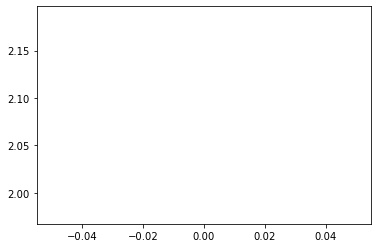

In [20]:
plt.plot(batch_errs)

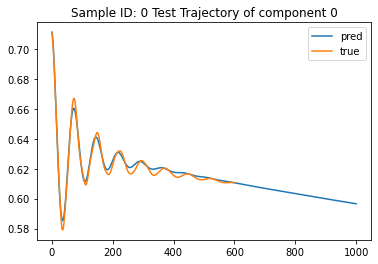

In [61]:
#test
x_pred = test_traj_plot(exp_rbl, rbl_test, n_step=1000, randcomp=False)

In [60]:
exp_rbl.save_weights('model_weights/exp_rbl.h5')

## Implicit Model ##

In [22]:
# Implicit model requires the force Jacobian, in this example it's T where T is tridiagonal
def jfrbl(y):
    '''
    y is a tensor with shape = (batch, 2). 
    When batch > 1, this must return a constant matrix, i.e., the force is linear.
    '''
    x = y @ L + 0.5
    dim_x = x.shape[-1] // 2
    block = tf.linalg.diag([-2.]*dim_x) + tf.linalg.diag([1.]*(dim_x-1), k=-1) + tf.linalg.diag([1.]*(dim_x-1), k=1) + tf.linalg.diag([1.], k=dim_x-1) + tf.linalg.diag([1.], k=1-dim_x)
    Tf = tf.concat([tf.concat([block, tf.zeros((dim_x,dim_x))], axis=1), tf.concat([tf.zeros((dim_x,dim_x)), block], axis=1)], axis=0)
    return 5e3*Tf @ tf.transpose(L)

In [23]:
time_steps = ts
r_dim = 2

# specify hidden dimension
hidden_dim = dimx

# build linear model
mid_rbl = build_const_mid_model(r_dim, dimx, hidden_dim, time_steps, c, k, frbl, jfrbl, E)
mid_rbl.summary()

Model: "const_mid_rom"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 200, 2)]          0         
_________________________________________________________________
rnn_1 (RNN)                  (None, 200, 2)            4160      
Total params: 4,160
Trainable params: 4,160
Non-trainable params: 0
_________________________________________________________________


In [31]:
mid_rbl.load_weights('model_weights/mid_rbl.h5')

In [24]:
train_step = train_fcns(mid_rbl, 1e-3)

In [25]:
batch_errs = []

In [26]:
errs = train_loop(1000, train_step)
batch_errs += errs

Training acc over epoch: 0.192647
Time taken: 0.05s
Training acc over epoch: 0.163071
Time taken: 0.06s
Training acc over epoch: 0.132103
Time taken: 0.05s
Training acc over epoch: 0.070293
Time taken: 0.05s
Training acc over epoch: 0.033087
Time taken: 0.06s
Training acc over epoch: 0.015935
Time taken: 0.05s
Training acc over epoch: 0.012472
Time taken: 0.05s
Training acc over epoch: 0.011081
Time taken: 0.06s
Training acc over epoch: 0.010578
Time taken: 0.05s
Training acc over epoch: 0.010325
Time taken: 0.05s
Training acc over epoch: 0.010133
Time taken: 0.05s
Training acc over epoch: 0.009961
Time taken: 0.05s
Training acc over epoch: 0.009801
Time taken: 0.04s
Training acc over epoch: 0.009656
Time taken: 0.06s
Training acc over epoch: 0.009529
Time taken: 0.06s
Training acc over epoch: 0.009419
Time taken: 0.06s
Training acc over epoch: 0.009327
Time taken: 0.05s
Training acc over epoch: 0.009252
Time taken: 0.05s
Training acc over epoch: 0.009193
Time taken: 0.07s
Training acc

In [30]:
np.save('data/rbl_batch_errs.npy', np.array(batch_errs))

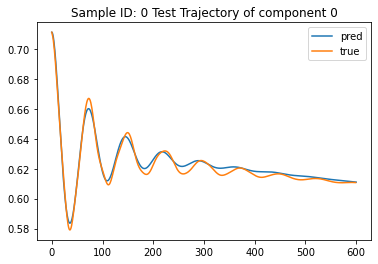

In [32]:
#test
xl_pred = test_traj_plot(mid_rbl, rbl_test, n_step=600, randcomp=False)

In [28]:
np.save('data/rbl_test.npy', rbl_test)
np.save('data/rbl_pred.npy', xl_pred)

In [22]:
def plot_snapshots(x_test, x_pred, test_step):
    test_step = min(test_step, x_test.shape[1]-1)
    x_true = np.append(x_test[0,test_step,:32], x_test[0,test_step,0]) 
    y_true = np.append(x_test[0,test_step,32:], x_test[0,test_step,32])
    x_p = np.append(x_pred[test_step,:32], x_pred[test_step,0])
    y_p = np.append(x_pred[test_step,32:], x_pred[test_step,32])
    fig, ax = plt.subplots()
    fig.set_size_inches(15, 15)
    ax.set_title(f"Snapshot at time step: {test_step}", fontsize=50)
    ax.plot(x_true, y_true, linewidth=5, label="true")
    ax.plot(x_p, y_p, '--', linewidth=5, label="pred")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('equal')
    ax.legend(prop={'size': 50}, loc=1)
    ax.set_xlim(0.2, 0.8)
    ax.set_ylim(0.2, 0.8)

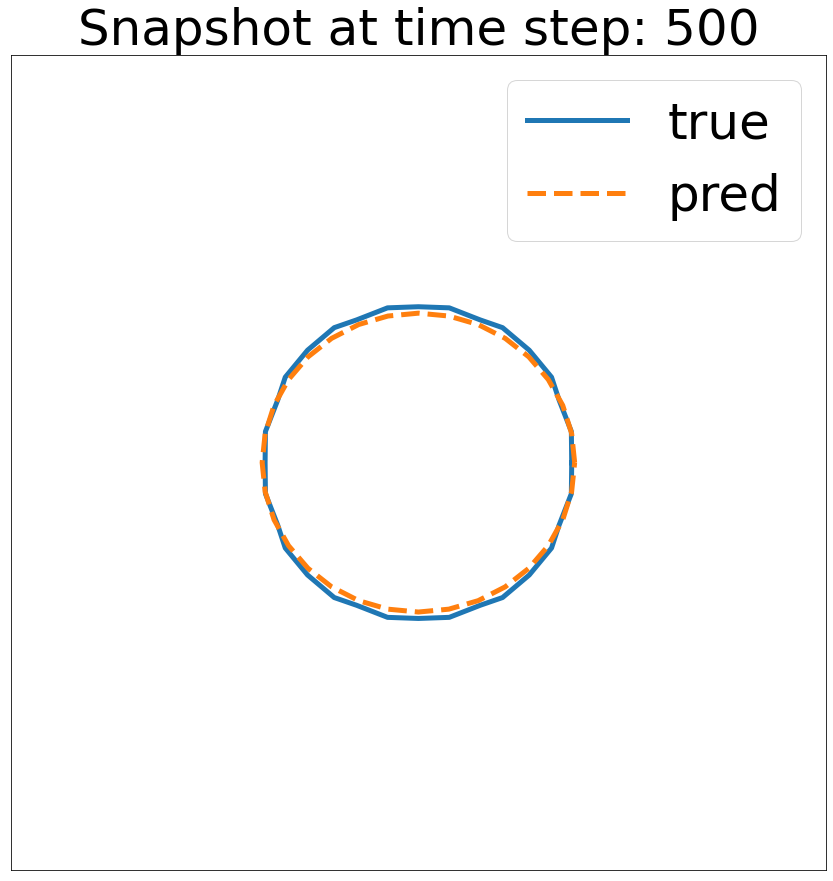

In [27]:
test_step = 500
plot_snapshots(rbl_test, xl_pred, test_step)
#plt.savefig(f"../Notes/rbl_snap{test_step}.png")

In [30]:
def plot_lens(x_test, x_pred, test_steps, dr=0.005):
    plen = min(x_test.shape[1], x_pred.shape[0])
    plen = min(plen, test_steps)
    l_true = []
    l_pred = []
    for i in range(plen):
        y_p = x_pred[i,32:]
        x_p = x_pred[i,:32]
        l_p = sum(np.sqrt((np.roll(y_p,1)-y_p)**2 + (np.roll(x_p,1)-x_p)**2))
        l_pred.append(l_p)
        y_t = x_test[0,i,32:]
        x_t = x_test[0,i,:32]
        l_t = sum(np.sqrt((np.roll(y_t,1)-y_t)**2 + (np.roll(x_t,1)-x_t)**2))
        l_true.append((l_t*np.exp(-dr*i)+l_p)/(1+np.exp(-dr*i)))
        #l_true.append(l_t)
    l_true = np.array(l_true)
    l_pred = np.array(l_pred)
    l_err = abs(l_true-l_pred)/l_true*100
    fig, ax = plt.subplots()
    fig.set_size_inches(15, 10)
    #ax.plot(l_true, label="true")
    #ax.plot(l_pred, '--', label="pred")
    #ax.legend(prop={'size': 16})
    #ax.set_ylabel('length', fontsize=18)
    ax.plot(l_err, linewidth = 7.0)
    ax.set_ylabel('error rate of length (%)', fontsize=30)
    ax.set_xlabel('time steps', fontsize=30)
    ax.tick_params(axis='both', labelsize=30)
    return l_true, l_pred, l_err

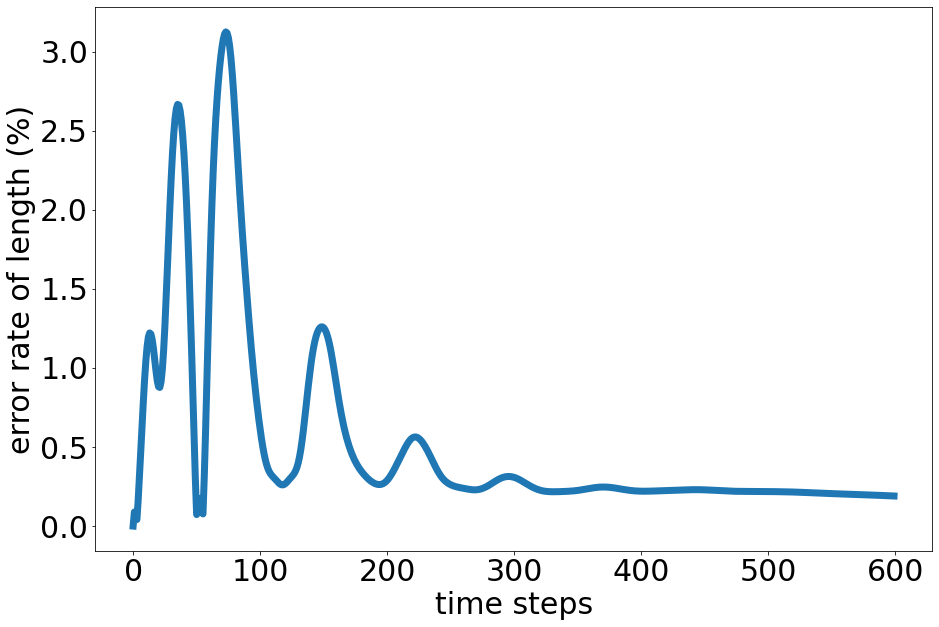

In [31]:
_, _, l_err = plot_lens(rbl_test, xl_pred, 600)
np.save('data/rbl_lerr.npy', l_err)
#plt.savefig(f"../Notes/rbl_lens_err.png")

In [90]:
mid_rbl.save_weights('model_weights/mid_rbl.h5')

# Nonlinear Force #
$F(y) = f(Ly+b)$ where $f$ is the nonlinear spring force with $d_{rest}=0.15$ and $k=2e3$.

In [138]:
# load data
filepath = '../matlab/fsi_rb_nl.mat'
xdata, c, k, fdata = load_matlab(filepath)
train_dataset, ts, rbnl_test = data_loader(xdata, k, cutoff=150)

force magnitude: 4.477365
dx magnitude: 0.001420


In [132]:
# force function (nonlinear)
def frbnl(ybatch):
    '''
    ybatch is a tensor with shape = (batch, 2)
    '''
    xbatch = ybatch @ L + 0.5
    dimx = xbatch.shape[1]//2
    x = xbatch[:, :dimx]
    y = xbatch[:, dimx:]

    dx = tf.roll(x, -1, 1) - x
    dy = tf.roll(y, -1, 1) - y

    r = 0.3*np.pi/dimx
    d = tf.sqrt(dx*dx+dy*dy)

    scale = (r/d-1)
    scale_s  = tf.roll(scale, 1, 1)

    t1x = scale*x
    t2x = scale_s*x
    myfxs = k * (t1x+t2x-tf.roll(t1x,1,1)-tf.roll(t2x,-1,1))

    t1y = scale*y
    t2y = scale_s*y
    myfys = 2e3 * (t1y+t2y-tf.roll(t1y,1,1)-tf.roll(t2y,-1,1))
    return tf.concat([myfxs, myfys], axis=1)

## Explicit Model ##

In [133]:
#build model
dimx = rbnl_test.shape[2]
rh_id = dimx // 8 * 5
E = np.zeros((dimx, 2))
E[0, 0] = 1
E[rh_id, 1] = 1

In [ ]:
time_steps = ts
r_dim = 2

# specify hidden dimension
hidden_dim = dimx

# build linear model
exp_rbnl = build_const_exp_model(r_dim, dimx, hidden_dim, time_steps, c, k, frbnl, E)
exp_rbnl.summary()

In [230]:
train_step = train_fcns(exp_rbnl, 1e-3)

In [235]:
train_loop(100, train_step)

Training acc over epoch: 0.595212
Time taken: 0.08s
Training acc over epoch: 0.588687
Time taken: 0.08s
Training acc over epoch: 0.582095
Time taken: 0.08s
Training acc over epoch: 0.575465
Time taken: 0.08s
Training acc over epoch: 0.568780
Time taken: 0.08s


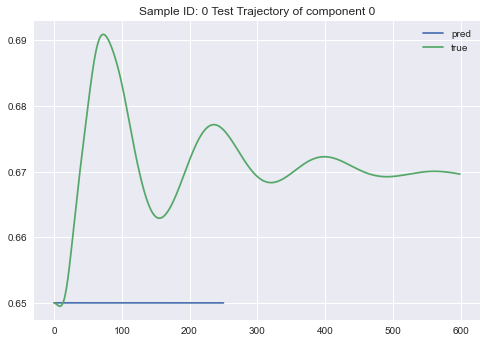

In [362]:
#test
xnl_pred = test_traj_plot(exp_rbnl, rbnl_test, n_step=250, randcomp=False)

## Implicit Model ##

In [134]:
# Implicit model requires the force Jacobian, in this example it depends on x and a constant r0.  
def jfrbnl(ybatch):
    '''
    ybatch is a tensor with shape = (batch, 2). 
    When batch > 1, this must return a constant matrix, i.e., the force is linear.
    '''
    xbatch = ybatch @ L + 0.5
    dimx = xbatch.shape[1]//2
    x = xbatch[0, :dimx]
    y = xbatch[0, dimx:]

    dx = tf.roll(x, -1, 0) - x
    dy = tf.roll(y, -1, 0) - y

    r = 0.3*np.pi/dimx
    d = tf.sqrt(dx*dx+dy*dy)
    
    a = 1-r*(dy*dy)/d
    b = 1-r*(dx*dx)/d
    c = r*dx*dy/(d*d*d)
    
    A = tf.linalg.diag(a+tf.roll(a,1,0)) - tf.linalg.diag(a[:-1], k=-1) - tf.linalg.diag(a[:-1], k=1) - tf.linalg.diag(a[-1:], k=1-dimx) - tf.linalg.diag(a[-1:], k=dimx-1)
    B = tf.linalg.diag(b+tf.roll(b,1,0)) - tf.linalg.diag(b[:-1], k=-1) - tf.linalg.diag(b[:-1], k=1) - tf.linalg.diag(b[-1:], k=1-dimx) - tf.linalg.diag(b[-1:], k=dimx-1)
    C = tf.linalg.diag(c+tf.roll(c,1,0)) - tf.linalg.diag(c[:-1], k=-1) - tf.linalg.diag(c[:-1], k=1) - tf.linalg.diag(c[-1:], k=1-dimx) - tf.linalg.diag(c[-1:], k=dimx-1)
    return -2e3*tf.concat([tf.concat([A, C], axis=1), tf.concat([C, B], axis=1)], axis=0) @ tf.transpose(L)

In [141]:
time_steps = ts
r_dim = 2

# specify hidden dimension
hidden_dim = dimx

# build linear model
mid_rbnl = build_const_mid_model(r_dim, dimx, hidden_dim, time_steps, c, k, frbnl, jfrbnl, E)
mid_rbnl.summary()

Model: "const_mid_rom"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 300, 2)]          0         
_________________________________________________________________
rnn_14 (RNN)                 (None, 300, 2)            4160      
Total params: 4,160
Trainable params: 4,160
Non-trainable params: 0
_________________________________________________________________


In [142]:
mid_rbnl.load_weights('model_weights/mid_rbnl.h5')

In [143]:
train_step = train_fcns(mid_rbnl, 1e-3)

In [144]:
batch_errs = []

In [149]:
errs = train_loop(200, train_step)
batch_errs += errs

In [154]:
np.save('data/rbnl_batch_errs.npy', np.array(batch_errs))

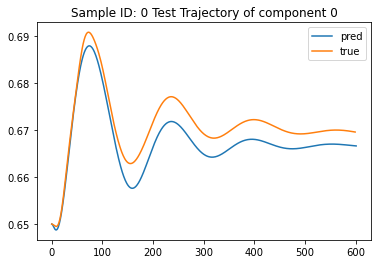

In [137]:
#test
xnl_pred = test_traj_plot(mid_rbnl, rbnl_test, n_step=601, randcomp=False)

In [38]:
np.save('data/rbnl_test.npy', rbnl_test)
np.save('data/rbnl_pred.npy', xnl_pred)

In [185]:
mid_rbnl.save_weights('model_weights/mid_rbnl.h5')

In [236]:
x_pred.shape

(601, 64)

In [237]:
rbnl_test.shape

(1, 600, 64)

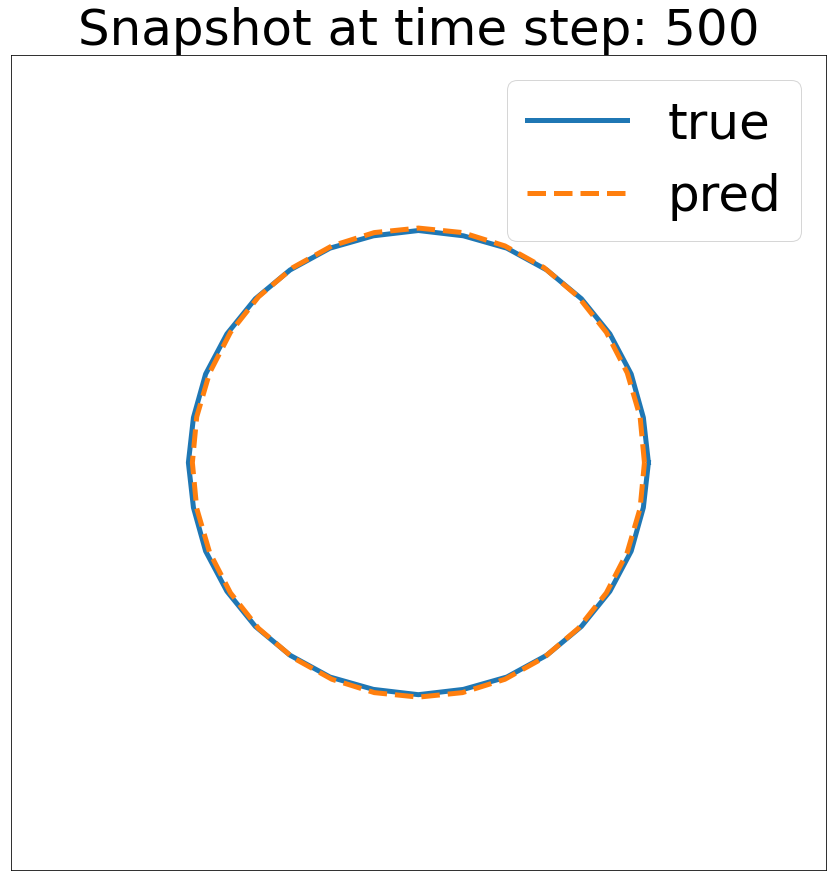

In [43]:
test_step = 500
plot_snapshots(rbnl_test, xnl_pred, test_step)
#plt.savefig(f"../Notes/rbnl_snap{test_step}.png")

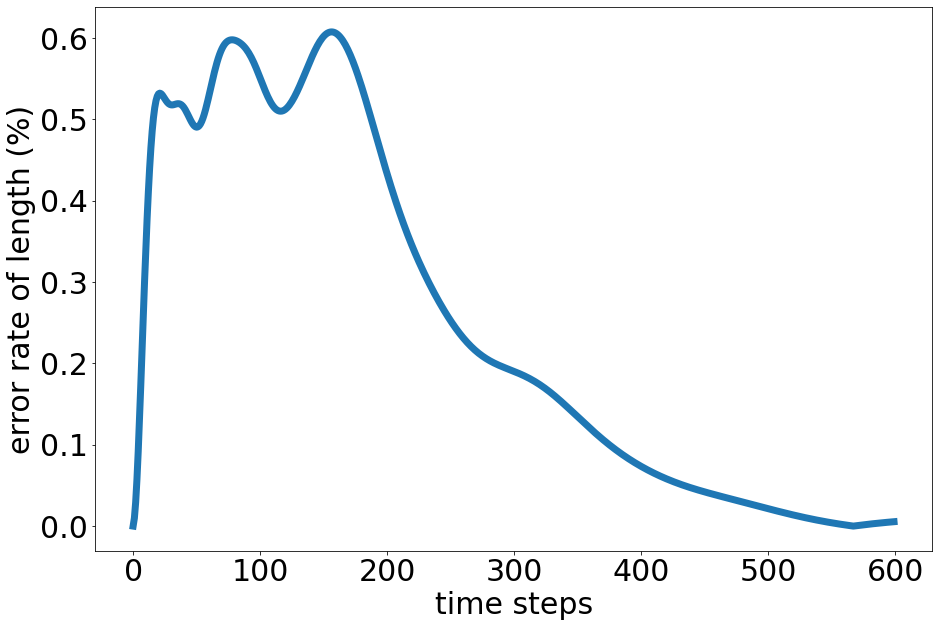

In [44]:
_, _, nl_err = plot_lens(rbnl_test, xnl_pred, 600)
np.save('data/rbnl_lerr.npy', nl_err)
#plt.savefig(f"../Notes/rbnl_lens_err.png")